<a href="https://colab.research.google.com/github/cs18b028/Object-Classification/blob/main/ObjectClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from PIL import Image
from torchvision.transforms import ToTensor
import random
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data collection

# 2. Data Cleaning


1.   Data Augmentation
2.   Data Enhanching - greyscaling/maxpooling 
3.   Resizing
4.   Shuffling properly



In [3]:
Clothes_Categories = ["Dresses", "Shirts", "Shorts", "Skirt", "T Shirt", "Trousers"]
Footwear_Categories = ["Sandals", "Shoes", "Slippers"]
labels = ["Footwear","Topwear","Dress","Short","Trouser"]

In [ ]:
def process_images(path, new_path, name):
  temp = os.listdir(path)
  files_list = [path + '/' + fname for fname in temp]
  for index, img_path in enumerate(files_list):
    try:
      image = Image.open(img_path).convert("L")
      image = image.resize((150, 112), Image.ANTIALIAS)
      image.save(new_path+f'/{name}_'+str(index)+'.jpg')
      print(new_path+f'/{name}_'+str(index)+'.jpg')
      datagen = ImageDataGenerator(
              rotation_range=40,
              width_shift_range=0.2,
              height_shift_range=0.2,
              shear_range=0.2,
              zoom_range=0.2,
              horizontal_flip=True,
              fill_mode='nearest')

      x = img_to_array(image) 
      x = x.reshape((1,) + x.shape) 
      i = 1
      for batch in datagen.flow(x, batch_size=1,
                                save_to_dir=new_path, save_prefix=cat, save_format='jpeg'):
          i += 1
          if i > 20:
              break
    except Exception as e:
      print(e)

In [ ]:
#Clothes Processing
clothes_path = '/content/drive/Shareddrives/AI ML Project/Clothes'
for cat in Clothes_Categories:
  folder_path = clothes_path+'/'+cat
  new_path = clothes_path+f'/{cat}_Processed'
  os.mkdir(new_path)
  process_images(folder_path, new_path, cat)

In [ ]:
footwear_path = '/content/drive/Shareddrives/AI ML Project/Footwear'
for cat in Footwear_Categories:
  folder_path = footwear_path+'/'+cat
  new_path = footwear_path+f'/{cat}_Processed'
  os.mkdir(new_path)
  process_images(folder_path, new_path, cat)

# 3. Clustering before labelling

In [44]:
import pickle

file_train_X = open('/content/drive/Shareddrives/AI ML Project/dataset_train_X','rb')
train_X = pickle.load(file_train_X)
file_train_X.close()

file_train_y = open('/content/drive/Shareddrives/AI ML Project/dataset_train_y','rb')
train_y = pickle.load(file_train_y)
file_train_y.close()

file_test_X = open('/content/drive/Shareddrives/AI ML Project/dataset_test_X','rb')
test_X = pickle.load(file_test_X)
file_test_X.close()

file_test_y = open('/content/drive/Shareddrives/AI ML Project/dataset_test_y','rb')
test_y = pickle.load(file_test_y)
file_test_y.close()

In [45]:
train_set = list(zip(train_X, train_y))
random.shuffle(train_set)
train_X, train_y = zip(*train_set)
train_X = list(train_X)
train_y = list(train_y)

In [46]:
test_set = list(zip(test_X, test_y))
random.shuffle(test_set)
test_X, test_y = zip(*test_set)
test_X =list(test_X)
test_y = list(test_y)

# 4. Feature Engineering

In [47]:
# type(train_X)
train_X = np.array(train_X)
train_X = train_X / 255
train_X_2d = train_X.reshape((-1, 112*150))
test_X = np.array(test_X)
test_X = test_X / 255
test_X_2d = test_X.reshape((-1, 112*150))
print(train_X.shape)

(5004, 112, 150, 1)


In [48]:
labels = ["Footwear","Topwear","Dress","Short","Trouser"]


for i in range(len(train_y)):
  if train_y[i] == "Dresses" or train_y[i] == "Skirt":
    train_y[i] = "Dress"
  elif train_y[i] == "T Shirt" or train_y[i] == "Shirts":
    train_y[i] = "Topwear"
  elif train_y[i] == "Sandals" or train_y[i] == "Shoes" or train_y[i] == "Slippers":
    train_y[i] = "Footwear"
  elif train_y[i] == "Trousers":
    train_y[i] = "Trouser"
  elif train_y[i] == "Shorts":
    train_y[i] = "Short"


for i in range(len(test_y)):
  if test_y[i] == "Dresses" or test_y[i] == "Skirt":
    test_y[i] = "Dress"
  elif test_y[i] == "T Shirt" or test_y[i] == "Shirts":
    test_y[i] = "Topwear"
  elif test_y[i] == "Sandals" or test_y[i] == "Shoes" or test_y[i] == "Slippers":
    test_y[i] = "Footwear"
  elif test_y[i] == "Trousers":
    test_y[i] = "Trouser"
  elif test_y[i] == "Shorts":
    test_y[i] = "Short"

In [49]:
X = np.concatenate((train_X_2d,test_X_2d))
print(X.shape)

(6260, 16800)


In [50]:
pca = PCA(2)
df = pca.fit_transform(X)

In [51]:
kmeans = KMeans(n_clusters= 5)
label = kmeans.fit_predict(df)
print(label)

[1 4 3 ... 2 4 1]


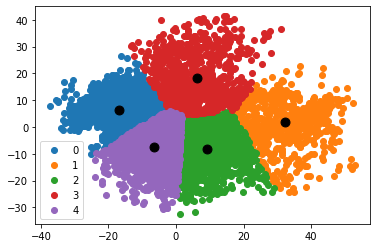

In [52]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

# 5. Manual Labelling

In [ ]:
def generate_data(path):
  temp = os.listdir(path)
  files_list = [path + '/' + fname for fname in temp]
  random.shuffle(files_list)
  train_size = int(4/5*len(files_list))
  train = []
  test = []
  for i, filename in enumerate(files_list[:train_size]):
    img = Image.open(filename)
    x = img_to_array(img)
    train.append(x)
    if i%10==0:
      print(f"{i} Train Done!")
  for i, filename in enumerate(files_list[train_size:]):
    img = Image.open(filename)
    x = img_to_array(img)
    test.append(x)
    if i%10==0:
      print(f"{i} Test Done!")
  return (train, test)

In [ ]:
train_X = []
train_y = []
test_X = []
test_y = []
for cat in Clothes_Categories:
  folder_path = f'/content/drive/Shareddrives/AI ML Project/Clothes/{cat}_Processed'
  (train, test) = generate_data(folder_path)
  # print(cat)
  train_X = train_X + train
  train_y = train_y + [cat]*len(train)
  test_X = test_X + test
  test_y = test_y + [cat]*len(test)

for cat in Footwear_Categories:
  folder_path = f'/content/drive/Shareddrives/AI ML Project/Footwear/{cat}_Processed'
  (train, test) = generate_data(folder_path)
  # print(cat)
  train_X = train_X + train
  train_y = train_y + [cat]*len(train)
  test_X = test_X + test
  test_y = test_y + [cat]*len(test)

In [ ]:
pickle.dump(train_X, open('/content/drive/Shareddrives/AI ML Project/dataset_train_X', "wb"))
pickle.dump(train_y, open('/content/drive/Shareddrives/AI ML Project/dataset_train_y', "wb"))
pickle.dump(test_X, open('/content/drive/Shareddrives/AI ML Project/dataset_test_X', "wb"))
pickle.dump(test_y, open('/content/drive/Shareddrives/AI ML Project/dataset_test_y', "wb"))

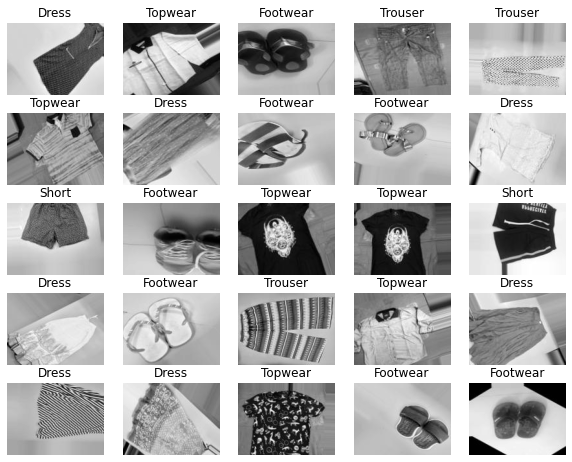

In [53]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    img = train_X[i]
    figure.add_subplot(rows, cols, i)
    plt.title(train_y[i])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [54]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(labels)
list(le.classes_)
print(train_y[:10], test_y[:10])
train_y = le.transform(train_y)
test_y = le.transform(test_y)
print(train_y[:10], test_y[:10])

['Trouser', 'Dress', 'Topwear', 'Footwear', 'Trouser', 'Trouser', 'Topwear', 'Dress', 'Footwear', 'Footwear'] ['Dress', 'Footwear', 'Topwear', 'Footwear', 'Trouser', 'Footwear', 'Footwear', 'Dress', 'Footwear', 'Trouser']
[4 0 3 1 4 4 3 0 1 1] [0 1 3 1 4 1 1 0 1 4]


# 6. Build Classifier

#### Analysis of Classifiers

In [15]:
# AUC Score
def calc_auc_score(y_test, y_prob, classes):

    for cls in classes:
        fpr, tpr, _ = roc_curve(y_test[:, cls],y_prob[:, cls])
        print(f"{cls} auc score:", auc(fpr, tpr))

In [16]:
!pip install scikit-plot

In [30]:
import heapq
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
import scikitplot as skplt

def find_example(model, x, y, true_class, predicted_class):
    y_true = y
    y_pred = model.predict(x)
    found_index = None
    for index, (current_y_true, current_y_pred) in enumerate(zip(y_true, y_pred)):
        if current_y_true == true_class and current_y_pred == predicted_class:
            found_index = index
            break
    return found_index

def plot_example(model, x, y, true_class, predicted_class, value=None):
    index = find_example(model, x, y, true_class, predicted_class)
    print('True class:', le.classes_[true_class])
    print('Predicted class:', le.classes_[predicted_class])
    if value is not None:
        print('Misclassified', value, 'times')
    if index is not None:
        plt.imshow(test_X[index].reshape(112, 150))
        plt.show()
    print('')
    
def analyze_model(model, x, y, inspect_n=10):
    y_pred = model.predict(x)

    y_probas = model.predict_proba(x)

    print(accuracy_score(y, y_pred))

    conf_matrix = confusion_matrix(y, y_pred)
    print('Confusion matrix:')
    print(conf_matrix)
    print('')
    for _ in range(len(labels)):
        conf_matrix[_][_] = 0
    conf_matrix_flat = conf_matrix.reshape(-1, 1)
    biggest_indices = heapq.nlargest(inspect_n, range(len(conf_matrix_flat)), conf_matrix_flat.take)
    biggest_indices = np.unravel_index(biggest_indices, conf_matrix.shape)
    highest_values = conf_matrix[biggest_indices]
    for x_index, y_index, value in zip(biggest_indices[0], biggest_indices[1], highest_values):
        plot_example(model, x, y, x_index, y_index, value)
    
    my_classes = np.unique(np.concatenate((train_y, test_y)))
    y1_test = label_binarize(y,classes=my_classes)

    skplt.metrics.plot_precision_recall_curve(y, y_probas)
    skplt.metrics.plot_roc_curve(y, y_probas)
    plt.show()

    calc_auc_score(y1_test, y_probas, my_classes)

####   Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, accuracy_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

In [19]:
model = RandomForestClassifier(n_estimators=128, n_jobs=-1)
model.fit(train_X_2d, train_y)

RandomForestClassifier(n_estimators=128, n_jobs=-1)

0.7555732484076433
Confusion matrix:
[[178  80   0   6   3]
 [ 15 542   0   3   3]
 [ 20  31   6  17   0]
 [  8   1   0 194   2]
 [ 30  59   0  29  29]]

True class: Dress
Predicted class: Footwear
Misclassified 80 times


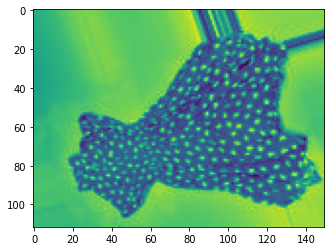


True class: Trouser
Predicted class: Footwear
Misclassified 59 times


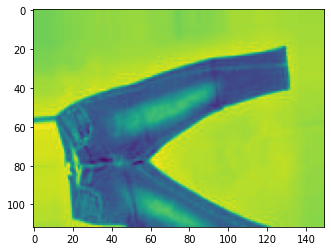


True class: Short
Predicted class: Footwear
Misclassified 31 times


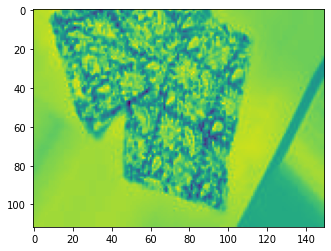


True class: Trouser
Predicted class: Dress
Misclassified 30 times


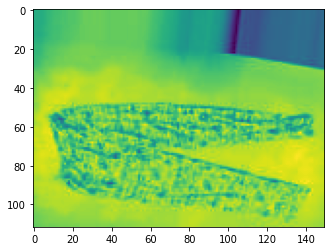


True class: Trouser
Predicted class: Topwear
Misclassified 29 times


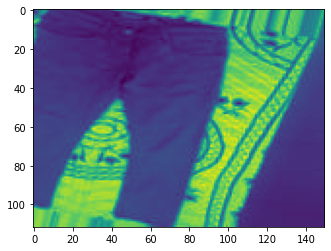


True class: Short
Predicted class: Dress
Misclassified 20 times


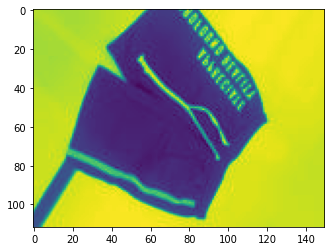


True class: Short
Predicted class: Topwear
Misclassified 17 times


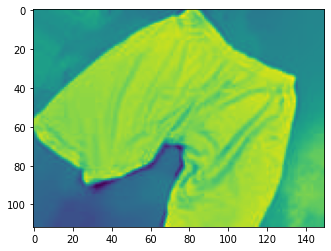


True class: Footwear
Predicted class: Dress
Misclassified 15 times


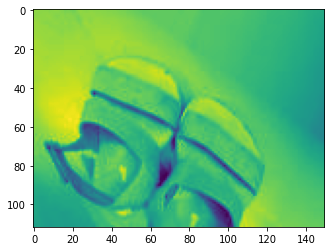


True class: Topwear
Predicted class: Dress
Misclassified 8 times


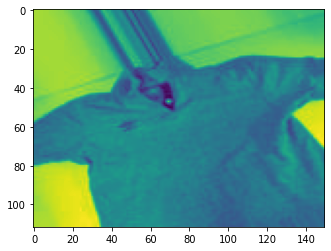


True class: Dress
Predicted class: Topwear
Misclassified 6 times


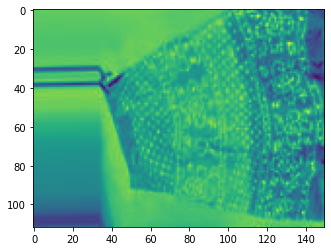

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


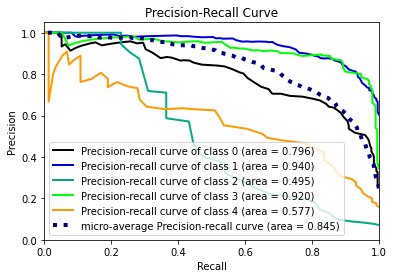

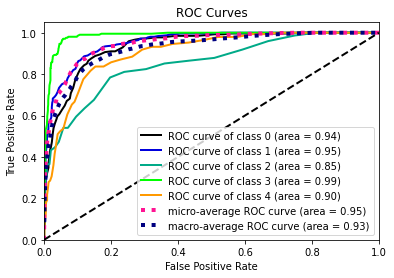

0 auc score: 0.9351631996909828
1 auc score: 0.9533228760582224
2 auc score: 0.8523231353180591
3 auc score: 0.9856837854772458
4 auc score: 0.9042098354219957


In [20]:
analyze_model(model,test_X_2d, test_y)

#### Decision Tree Classifier

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
dec_tree_clf = DecisionTreeClassifier(max_depth=50, random_state=42)
dec_tree_clf.fit(train_X_2d, train_y)

DecisionTreeClassifier(max_depth=50, random_state=42)

In [23]:
y_test_predict = dec_tree_clf.predict(test_X_2d)
dec_tree_accuracy = accuracy_score(test_y, y_test_predict)
dec_tree_precision = precision_score(test_y, y_test_predict, average='weighted')
dec_tree_recall = recall_score(test_y, y_test_predict, average='weighted')
dec_tree_f1_score = f1_score(test_y, y_test_predict, average='weighted')


print("Decision Tree Accuracy: ", dec_tree_accuracy)
print("Decision Tree Precision: ", dec_tree_precision)
print("Decision Tree Recall: ", dec_tree_precision)
print("Decision Tree F1 Score: ", dec_tree_f1_score)

Decision Tree Accuracy:  0.5477707006369427
Decision Tree Precision:  0.5656635749513199
Decision Tree Recall:  0.5656635749513199
Decision Tree F1 Score:  0.55585534638763


0.5477707006369427
Confusion matrix:
[[122  63  23  18  41]
 [ 94 377  27  13  52]
 [ 20  22  10   9  13]
 [ 13  11  11 142  28]
 [ 38  45  10  17  37]]

True class: Footwear
Predicted class: Dress
Misclassified 94 times


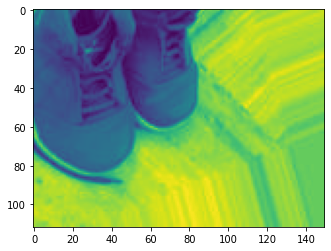


True class: Dress
Predicted class: Footwear
Misclassified 63 times


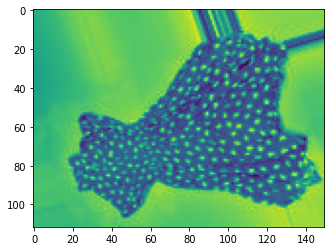


True class: Footwear
Predicted class: Trouser
Misclassified 52 times


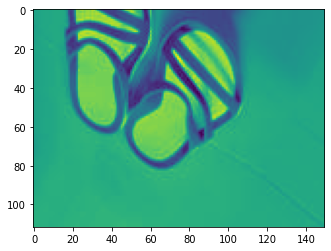


True class: Trouser
Predicted class: Footwear
Misclassified 45 times


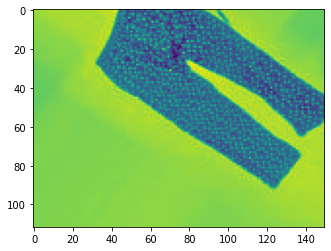


True class: Dress
Predicted class: Trouser
Misclassified 41 times


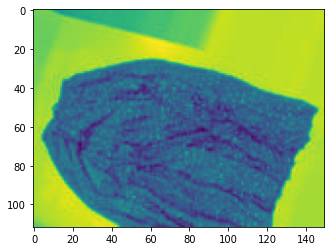


True class: Trouser
Predicted class: Dress
Misclassified 38 times


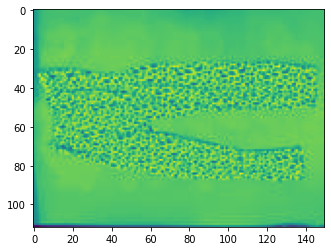


True class: Topwear
Predicted class: Trouser
Misclassified 28 times


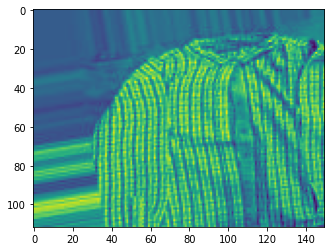


True class: Footwear
Predicted class: Short
Misclassified 27 times


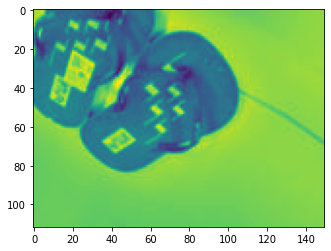


True class: Dress
Predicted class: Short
Misclassified 23 times


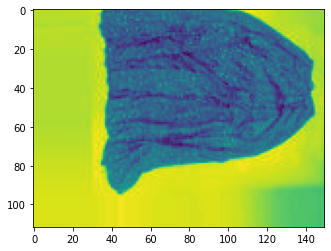


True class: Short
Predicted class: Footwear
Misclassified 22 times


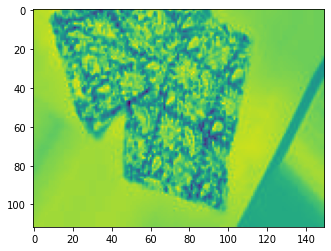

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


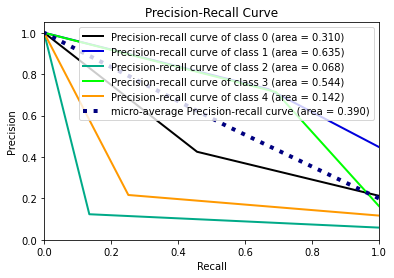

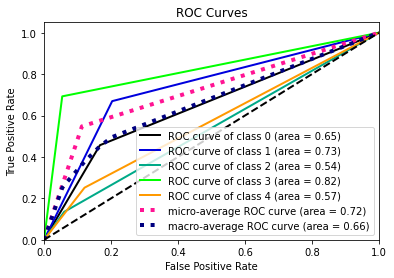

0 auc score: 0.6450468259468384
1 auc score: 0.7330818973802988
2 auc score: 0.5375337266200211
3 auc score: 0.8192244320159661
4 auc score: 0.5654355520386694


In [24]:
analyze_model(dec_tree_clf, test_X_2d, test_y)

#### SVM

In [25]:
from sklearn import svm
clf = svm.SVC(gamma=0.1, kernel='poly', probability=True)
clf.fit(train_X_2d,train_y)

SVC(gamma=0.1, kernel='poly', probability=True)

In [26]:
y_pred = clf.predict(test_X_2d)

print('\nCalculating Accuracy of Predictions...')
accuracy = accuracy_score(test_y, y_pred)
print(accuracy)


Calculating Accuracy of Predictions...
0.6226114649681529


0.6226114649681529
Confusion matrix:
[[131 106   8   4  18]
 [ 76 424  23  14  26]
 [ 31  13  11  14   5]
 [  7   5   7 172  14]
 [ 40  37   7  19  44]]

True class: Dress
Predicted class: Footwear
Misclassified 106 times


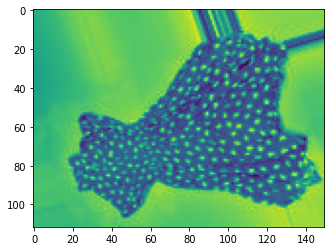


True class: Footwear
Predicted class: Dress
Misclassified 76 times


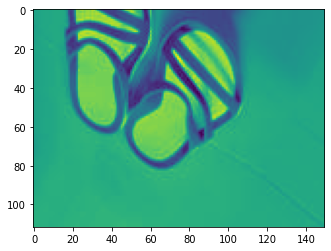


True class: Trouser
Predicted class: Dress
Misclassified 40 times


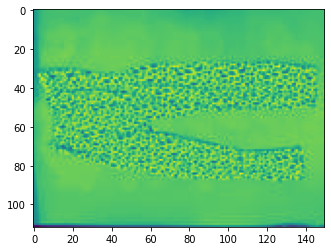


True class: Trouser
Predicted class: Footwear
Misclassified 37 times


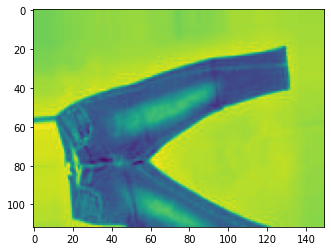


True class: Short
Predicted class: Dress
Misclassified 31 times


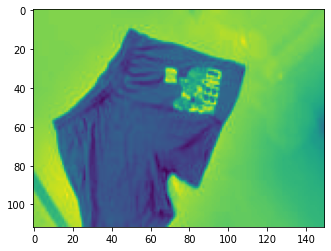


True class: Footwear
Predicted class: Trouser
Misclassified 26 times


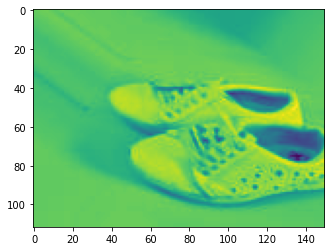


True class: Footwear
Predicted class: Short
Misclassified 23 times


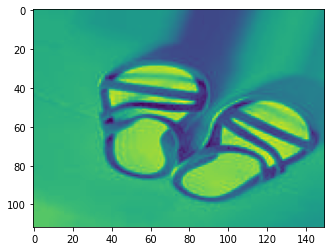


True class: Trouser
Predicted class: Topwear
Misclassified 19 times


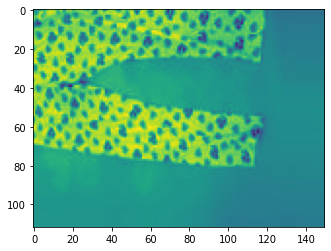


True class: Dress
Predicted class: Trouser
Misclassified 18 times


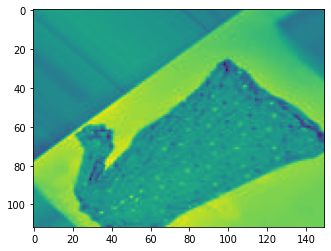


True class: Footwear
Predicted class: Topwear
Misclassified 14 times


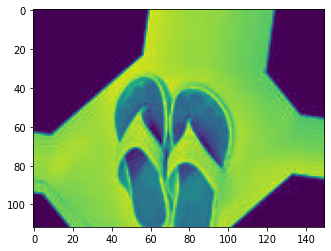

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


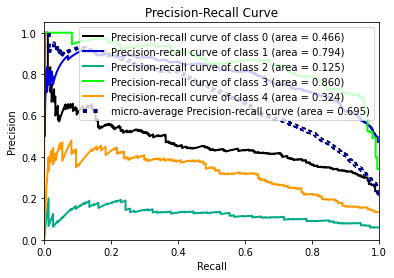

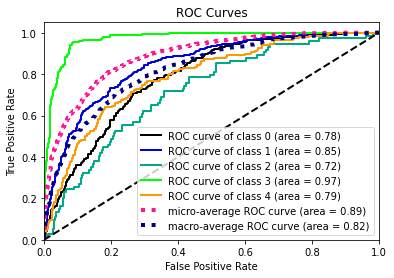

0 auc score: 0.7844037218391067
1 auc score: 0.8462601144661535
2 auc score: 0.7170165088946815
3 auc score: 0.9715578659116753
4 auc score: 0.7894652901737791


In [27]:
analyze_model(clf, test_X_2d, test_y)

#### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
print(np.mean(cross_val_score(estimator=naive_bayes, cv=4, scoring='accuracy', X=train_X, y=train_y)))
naive_bayes.fit(train_X_2d, train_y)

0.45302547770700635
Confusion matrix:
[[140  50  34   7  36]
 [181 239  51  58  34]
 [ 32   9   7  13  13]
 [  1   0  11 163  30]
 [ 52  23   8  44  20]]

True class: Footwear
Predicted class: Dress
Misclassified 181 times


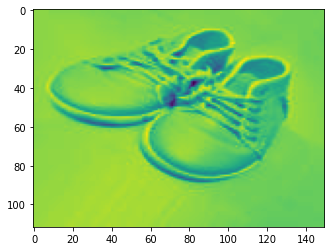


True class: Footwear
Predicted class: Topwear
Misclassified 58 times


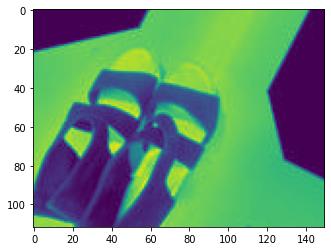


True class: Trouser
Predicted class: Dress
Misclassified 52 times


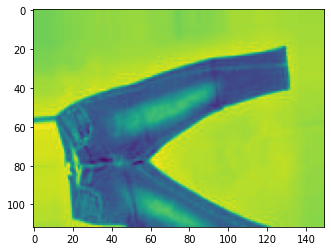


True class: Footwear
Predicted class: Short
Misclassified 51 times


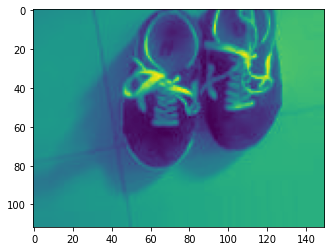


True class: Dress
Predicted class: Footwear
Misclassified 50 times


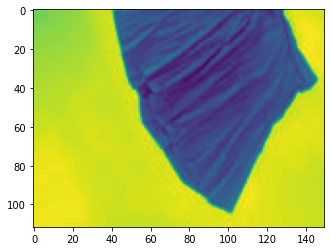


True class: Trouser
Predicted class: Topwear
Misclassified 44 times


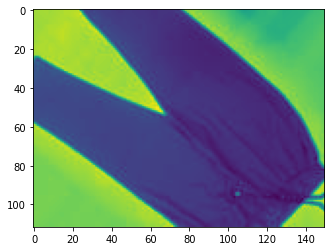


True class: Dress
Predicted class: Trouser
Misclassified 36 times


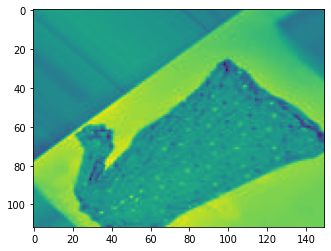


True class: Dress
Predicted class: Short
Misclassified 34 times


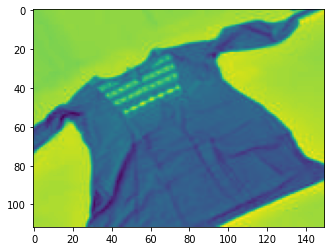


True class: Footwear
Predicted class: Trouser
Misclassified 34 times


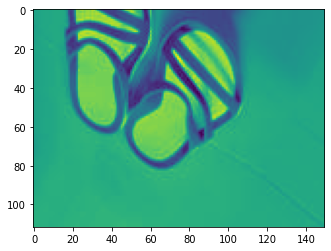


True class: Short
Predicted class: Dress
Misclassified 32 times


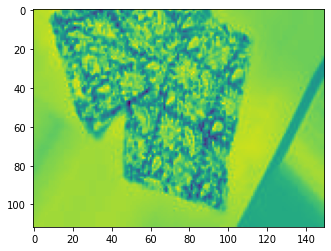

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


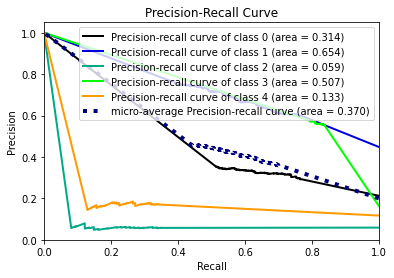

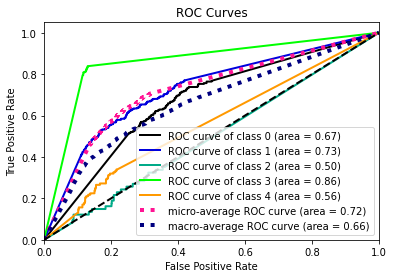

0 auc score: 0.6693516319969098
1 auc score: 0.7256785054298377
2 auc score: 0.4961814606484657
3 auc score: 0.857503887122601
4 auc score: 0.5594732031676511


In [34]:
analyze_model(naive_bayes, test_X_2d, test_y)

#### XGBoost

In [35]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(n_estimators=20, max_depth=10, random_state=42)
xgb_clf.fit(train_X_2d, train_y)

XGBClassifier(max_depth=10, n_estimators=20, objective='multi:softprob',
              random_state=42)

0.7531847133757962
Confusion matrix:
[[167  84   3   5   8]
 [ 17 536   2   2   6]
 [ 21  29  11  12   1]
 [ 11   1   0 190   3]
 [ 30  50   0  25  42]]

True class: Dress
Predicted class: Footwear
Misclassified 84 times


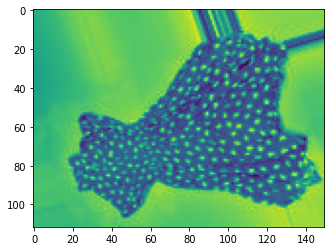


True class: Trouser
Predicted class: Footwear
Misclassified 50 times


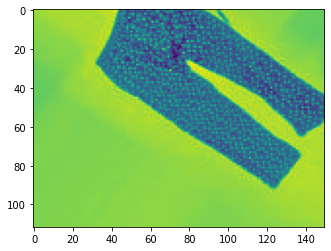


True class: Trouser
Predicted class: Dress
Misclassified 30 times


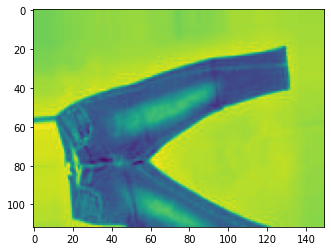


True class: Short
Predicted class: Footwear
Misclassified 29 times


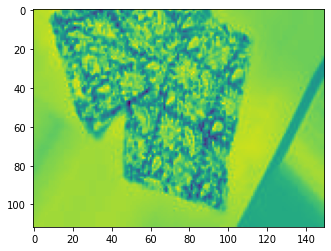


True class: Trouser
Predicted class: Topwear
Misclassified 25 times


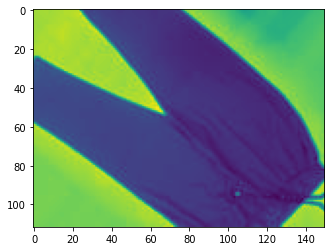


True class: Short
Predicted class: Dress
Misclassified 21 times


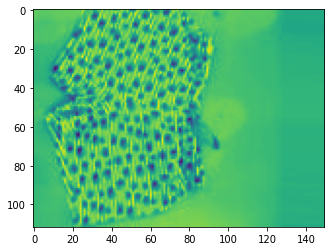


True class: Footwear
Predicted class: Dress
Misclassified 17 times


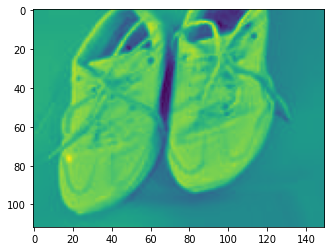


True class: Short
Predicted class: Topwear
Misclassified 12 times


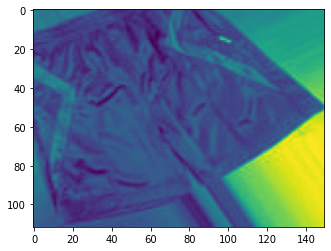


True class: Topwear
Predicted class: Dress
Misclassified 11 times


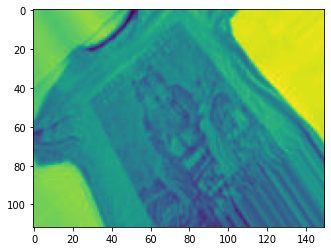


True class: Dress
Predicted class: Trouser
Misclassified 8 times


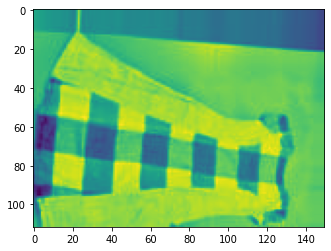

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


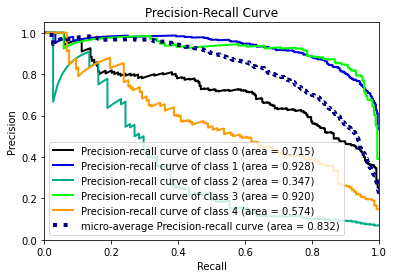

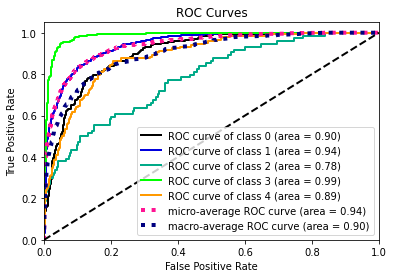

0 auc score: 0.90353438384022
1 auc score: 0.9438049615669508
2 auc score: 0.7818973796131157
3 auc score: 0.9854772458285952
4 auc score: 0.888567870791238


In [36]:
analyze_model(xgb_clf, test_X_2d, test_y)

#### CNN

In [37]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.metrics import sparse_categorical_accuracy, sparse_categorical_crossentropy

In [38]:
class ConvModel:
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y, **kwargs):
        self.model.fit(X, y, **kwargs)
        
    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)

    def predict_proba(self, X):
        return self.model.predict(X)  

In [40]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='sigmoid', input_shape=(112, 150, 1)))
model.add(Conv2D(8, (3, 3), activation='sigmoid'))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=[sparse_categorical_accuracy])

conv_model_2c_1d = ConvModel(model)
conv_model_2c_1d.fit(train_X, train_y, batch_size=32, epochs=10, validation_data=(test_X, test_y))

Epoch 1/10
157/157 [==============================] - 66s 415ms/step - loss: 6.0688 - sparse_categorical_accuracy: 0.3965 - val_loss: 1.3964 - val_sparse_categorical_accuracy: 0.4482
Epoch 2/10
157/157 [==============================] - 65s 413ms/step - loss: 1.3546 - sparse_categorical_accuracy: 0.4774 - val_loss: 1.2803 - val_sparse_categorical_accuracy: 0.4928
Epoch 3/10
157/157 [==============================] - 65s 414ms/step - loss: 1.2657 - sparse_categorical_accuracy: 0.5124 - val_loss: 1.1919 - val_sparse_categorical_accuracy: 0.5454
Epoch 4/10
157/157 [==============================] - 65s 415ms/step - loss: 1.1955 - sparse_categorical_accuracy: 0.5332 - val_loss: 1.1623 - val_sparse_categorical_accuracy: 0.5533
Epoch 5/10
157/157 [==============================] - 65s 413ms/step - loss: 1.1595 - sparse_categorical_accuracy: 0.5462 - val_loss: 1.1282 - val_sparse_categorical_accuracy: 0.5462
Epoch 6/10
157/157 [==============================] - 65s 414ms/step - loss: 1.1476 -

In [41]:
pickle.dump(conv_model_2c_1d, open('/content/drive/Shareddrives/AI ML Project/conv_model_2c_1d', "wb"))

INFO:tensorflow:Assets written to: ram://0bcc1b3e-046f-42d6-bb86-8b1b9902ff77/assets


0.5461783439490446
Confusion matrix:
[[106 142   0   5  14]
 [108 393   0  35  27]
 [ 17  34   0  15   8]
 [  1  16   0 169  19]
 [ 45  58   0  26  18]]

True class: Dress
Predicted class: Footwear
Misclassified 142 times


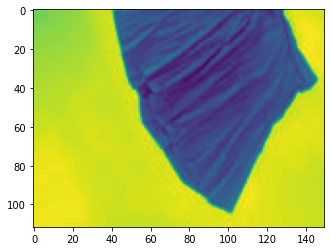


True class: Footwear
Predicted class: Dress
Misclassified 108 times


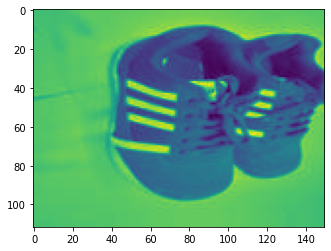


True class: Trouser
Predicted class: Footwear
Misclassified 58 times


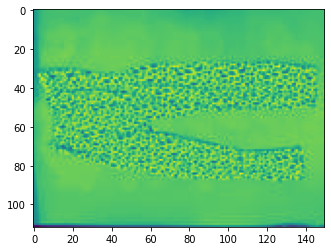


True class: Trouser
Predicted class: Dress
Misclassified 45 times


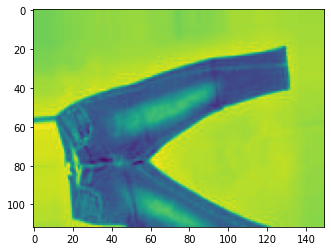


True class: Footwear
Predicted class: Topwear
Misclassified 35 times


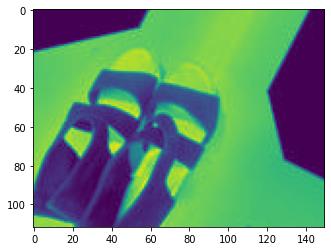


True class: Short
Predicted class: Footwear
Misclassified 34 times


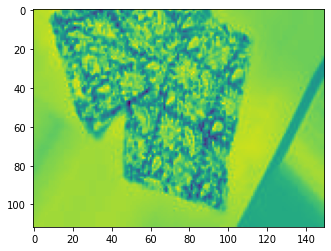


True class: Footwear
Predicted class: Trouser
Misclassified 27 times


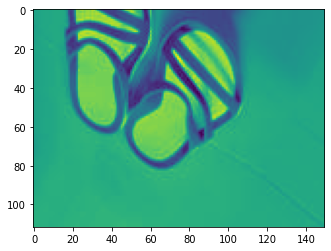


True class: Trouser
Predicted class: Topwear
Misclassified 26 times


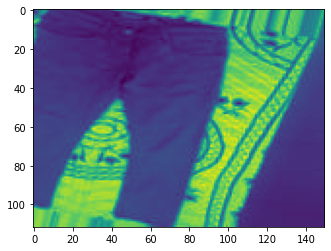


True class: Topwear
Predicted class: Trouser
Misclassified 19 times


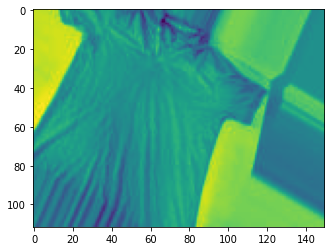


True class: Short
Predicted class: Dress
Misclassified 17 times


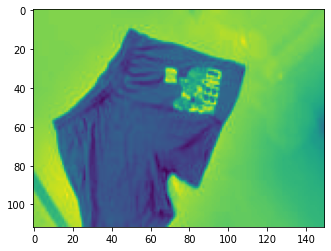

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


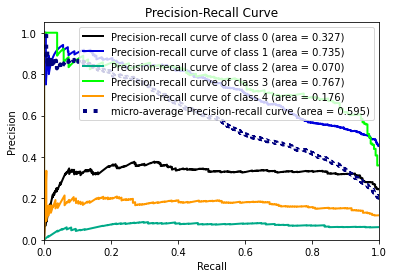

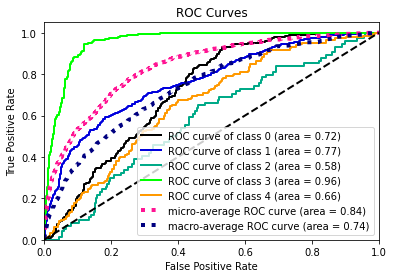

0 auc score: 0.7183475155550002
1 auc score: 0.765751911400224
2 auc score: 0.5795833904970961
3 auc score: 0.9555870135295073
4 auc score: 0.6589131594928322


In [42]:
analyze_model(conv_model_2c_1d, test_X, test_y)

# 7. Compare multiple classifiers on the same data set and provide your observation

For the above 6 models, comparing the accuracies and auc score values, we could see that the random forest performed better on our dataset than the other 5 models. 

# 8. Perform post-processing on the output score to refine presentation

We initially had 9 categories. The accuracy score for the models was as follows:

1.   Random Forest - around 60%
2.   Decision Tree - around 50%
3.   CNNs - around 30%

After looking at the PR and ROC curves and also after analysing the mispredictions on some classes of the model, we have decided to combine the classes. Finally, we have 5 categories.
